<center><h1> A Tutorial for Beginners. </h1></center>

***


<center><h2> On How to train A neural network for image Segmentation using Fast.ai and Transfer Learning</h2></center>


***

<center><img src="https://github.com/shadab4150/Aerial_drone_image_segmentation/raw/master/image_drone/drone1.png"></center>


<center><h3> Please Upvote if you like it. </h3></center>

## What is semantic segmentation ?

* Source: **https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html**

* **Semantic image segmentation is the task of classifying each pixel in an image from a predefined set of classes.**

***

In the following example, different entities are classified.

![kd](https://divamgupta.com/assets/images/posts/imgseg/image15.png?style=centerme)

***


In the above example, the pixels belonging to the bed are classified in the class “bed”, the pixels corresponding to the walls are labeled as “wall”, etc.

In particular, our goal is to take an image of size W x H x 3 and generate a W x H matrix containing the predicted class ID’s corresponding to all the pixels.

***
![kd](https://divamgupta.com/assets/images/posts/imgseg/image14.png?style=centerme)

***

Usually, in an image with various entities, we want to know which pixel belongs to which entity, For example in an outdoor image, we can segment the sky, ground, trees, people, etc.

## Importing useful libraries

In [3]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.callbacks import SaveModelCallback
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as immg
import gc
import numpy as np
import random
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

In [32]:
open_image('../input/semantic-drone-dataset/semantic_drone_dataset/original_images/001.jpg').data.shape

torch.Size([3, 4000, 6000])

## Path to the dataset
* Images were too big from original dataset So, resized them in 2 size
* > 1800x1200
* > 600x400

In [4]:
path = Path('../input/drone-images-mask-resized/drone_data_small')  

In [5]:
path.ls()

[PosixPath('../input/drone-images-mask-resized/drone_data_small/label_small'),
 PosixPath('../input/drone-images-mask-resized/drone_data_small/train_small')]

In [6]:
fnames = get_files(path/'train_small')
fnames_mask = get_files(path/'label_small')

In [7]:
open_image(fnames[4]).data.shape

torch.Size([3, 400, 600])

## Data PreProcessing

In [8]:
from tqdm.notebook import tqdm,tnrange

* Since each pixel belongs to a diffrent class below function counts total number of such classes

In [11]:
path_im = path/'train_small'
path_lb = path/'label_small'
get_y_fns = lambda x: path_lb/f'{x.stem}.png'       # Function to get masks for a image

In [12]:
fnames[30],get_y_fns(fnames[30])

(PosixPath('../input/drone-images-mask-resized/drone_data_small/train_small/554.jpg'),
 PosixPath('../input/drone-images-mask-resized/drone_data_small/label_small/554.png'))

In [13]:
def get_classes(fnames):
    class_codes=[]
    for i in tqdm(range(400)):
        class_codes += list(np.unique(np.asarray(Image.open(get_y_fns(fnames[i])))))
    return np.array(list(set(class_codes)))

In [14]:
# Run this once to get total classes if you want, other wise below cell gives total classes
codes = get_classes(fnames)  

In [15]:
codes = np.array(codes)
codes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
      dtype=uint8)

In [16]:
sns.set_style('darkgrid')

## Function to show chest X_ray with Mask

In [18]:
def drone_mask(f):  # f = file_name
  img_a = immg.imread(f)
  img_a_mask = immg.imread(get_y_fns(f))
  plt.figure(1,figsize=(20,8))
  plt.subplot(121)
  plt.imshow(img_a);plt.title('Raw Drone footage ');plt.axis('off')
  plt.subplot(122)
  plt.imshow(img_a,alpha=0.8);
  plt.imshow(img_a_mask,alpha=0.8);plt.title('Drone with  mask');plt.axis('off')
  plt.show()

## A sample X-ray with Mask

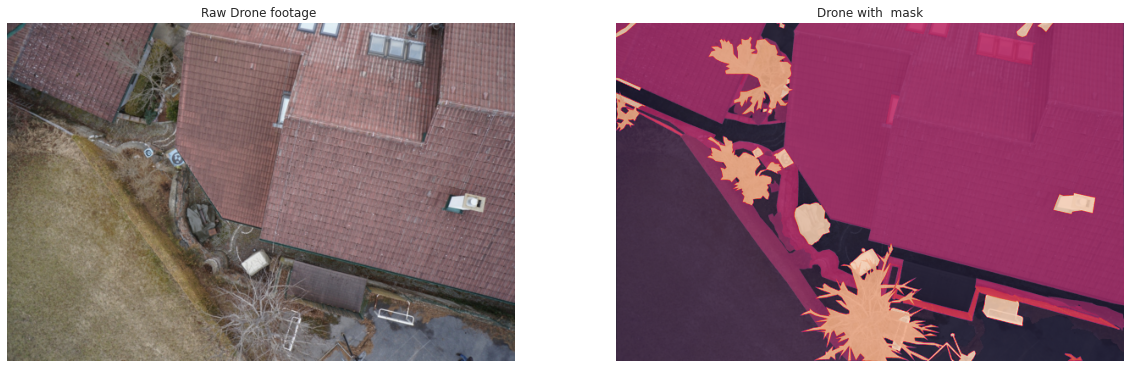

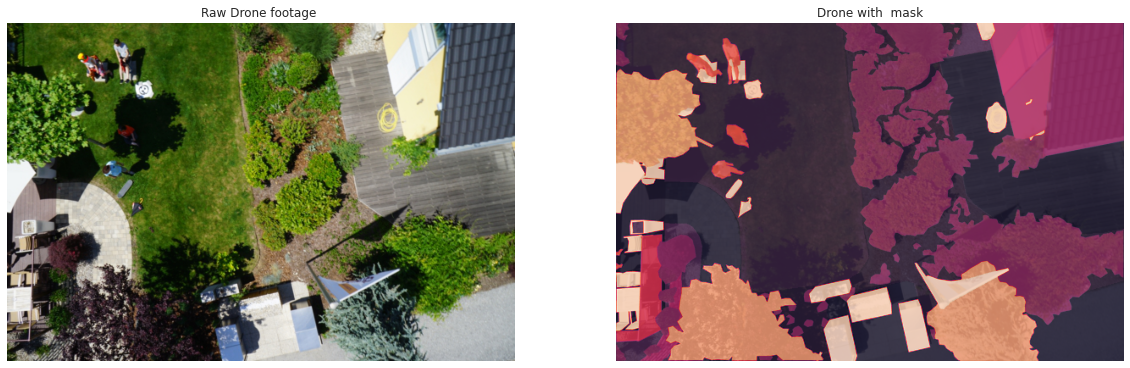

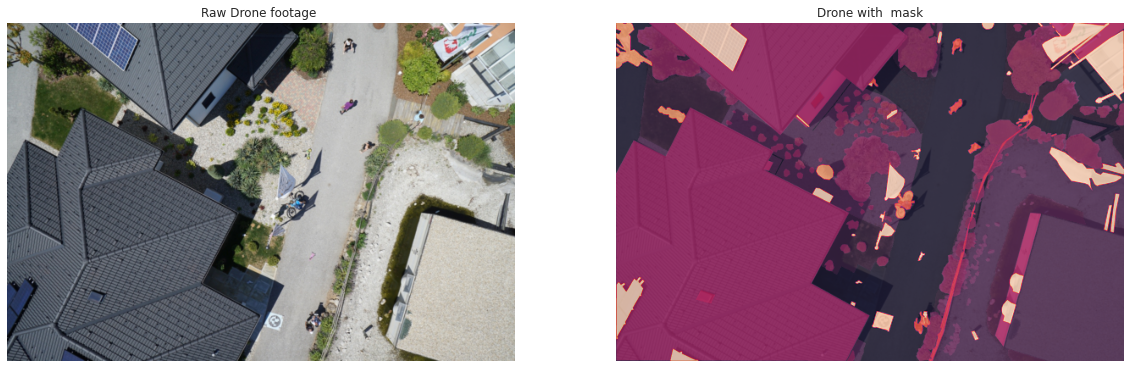

In [21]:
for i in range(3):
    img_num = random.randint(10,200)
    drone_mask(fnames[img_num])

## Creating A DatabLock for the model

In [22]:
src=np.array([400,600])
#src=src//2
src

array([400, 600])

In [23]:
data = (SegmentationItemList.from_folder(path=path_im)  # Location from path
        .split_by_rand_pct(0.2)                          # Split for train and validation set
        .label_from_func(get_y_fns, classes=codes)      # Label from a above defined function
        .transform(get_transforms(), size=src, tfm_y=True)   # If you want to apply any image Transform
        .databunch(bs=4)                                   # Batch size  please decrese batch size if cuda out of memory
        .normalize(imagenet_stats))            # Normalise with imagenet stats

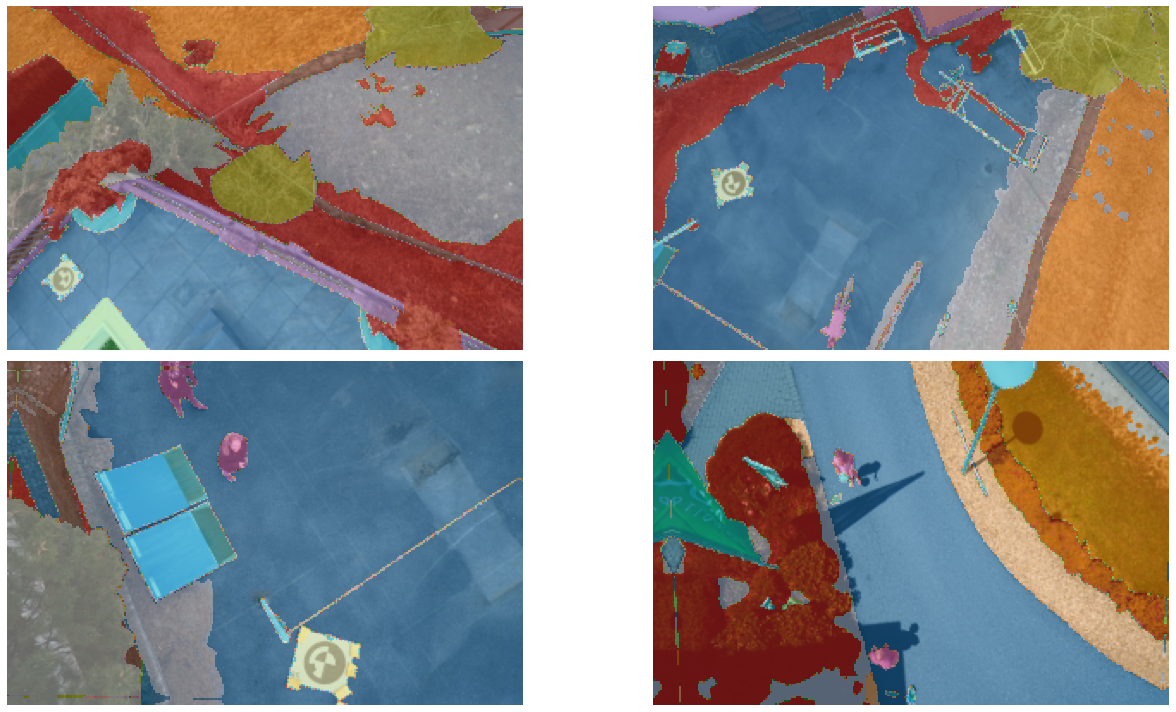

In [24]:
data.show_batch(rows=2,figsize=(20,10));

In [25]:
len(data.train_ds), len(data.valid_ds), data.c  

(320, 80, 26)

# Model

* **Metrics for Drone mask**


In [26]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = -1

def drone_accuracy_mask(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [27]:
metrics = drone_accuracy_mask
wd=1e-2    # wd = weight decay

### Fastai's unet_learner
* Source [**Fast.ai**](www.fast.ai)

* This module builds a dynamic U-Net from any backbone **pretrained on ImageNet**, automatically inferring the intermediate sizes.

![kd](https://docs.fast.ai/imgs/u-net-architecture.png)

* **This is the original U-Net. The difference here is that the left part is a pretrained model.**

* **This U-Net will sit on top of an encoder ( that can be a pretrained model -- eg. resnet50 ) and with a final output of num_classes.**

In [ ]:
arch = models.resnet50
learn = unet_learner(data, # DatBunch
                     arch, # Backbone pretrained arch
                     metrics = [metrics], # metrics
                     wd = wd, bottle=True, # weight decay
                     model_dir = '/kaggle/working/') # model directory to save

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


## Finding a suitable learning rate for our model

* With help fast.ai **learning rate finder** function

In [29]:
callbacks = SaveModelCallback(learn, monitor = 'drone_accuracy_mask', every = 'improvement',mode='max', name = 'best_model' )

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


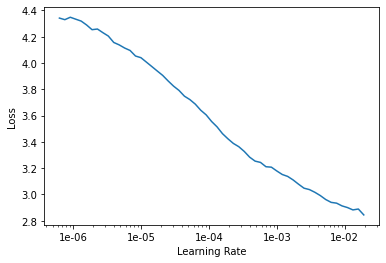

In [33]:
learn.lr_find()
learn.recorder.plot()

In [34]:
gc.collect() # to clear the cache

6467

In [30]:
lr = 1e-3           # Learning Rate

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start = 0.8,callbacks = [callbacks] )

In [31]:
learn.fit_one_cycle(10, slice(lr), pct_start = 0.8,callbacks = [callbacks] )

Better model found at epoch 0 with drone_accuracy_mask value: 0.4836856424808502.
Better model found at epoch 1 with drone_accuracy_mask value: 0.6183198094367981.
Better model found at epoch 2 with drone_accuracy_mask value: 0.6592585444450378.
Better model found at epoch 3 with drone_accuracy_mask value: 0.691440224647522.
Better model found at epoch 7 with drone_accuracy_mask value: 0.6985127329826355.
Better model found at epoch 8 with drone_accuracy_mask value: 0.7487287521362305.
Better model found at epoch 9 with drone_accuracy_mask value: 0.7718838453292847.


## To check results of our trained model

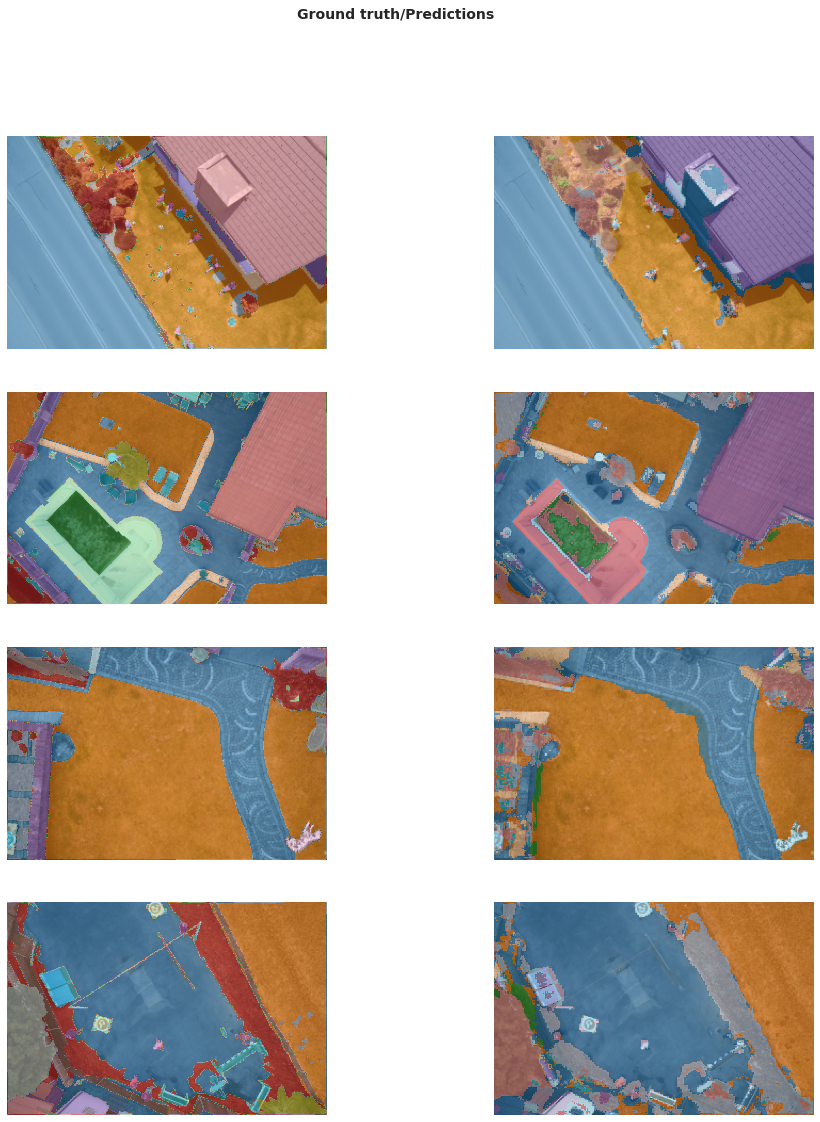

In [35]:
learn.show_results(rows = 4, figsize=(16,18))

In [36]:
learn.save('stage-1-big')  # saving the model 

## Export the model

In [37]:
learn.export('/kaggle/working/drone_mask.pkl')

### Load the model  and predict

* **Function to make a prediction and Overlap the Drone Images with Predicted Drone Mask**

In [87]:
def drone_predict(f):
    img = open_image(f).resize((3,200,300))
    mask = learn.predict(img)[0]
    _,axs = plt.subplots(1,3, figsize=(24,10))
    img.show(ax=axs[0], title='no mask')
    img.show(ax=axs[1], y=mask, title='masked')
    mask.show(ax=axs[2], title='mask only', alpha=1.)

### Prediction

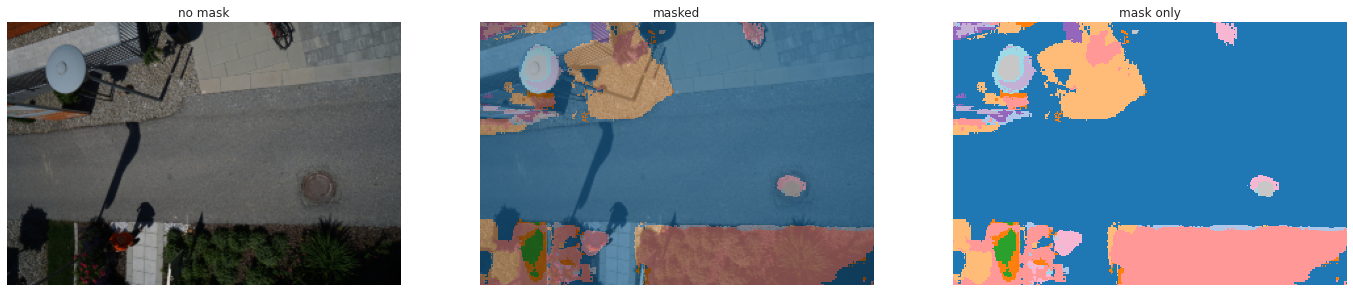

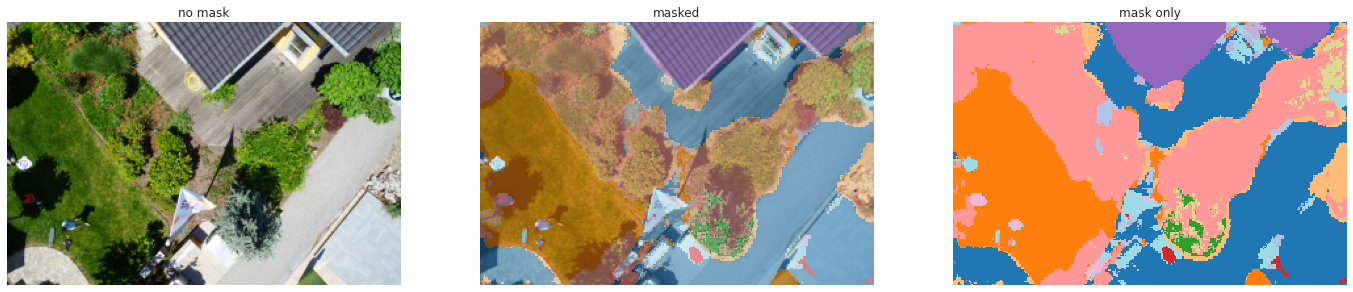

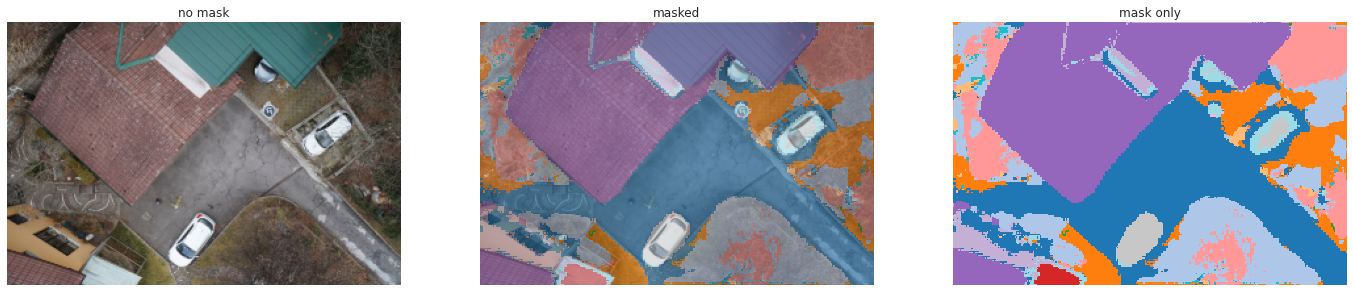

In [92]:
for i in range(3):
    n = random.randint(20,200)
    drone_predict(fnames[n])

## Model Summary

In [74]:
print(learn.summary())

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 100, 150]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 100, 150]       128        True      
______________________________________________________________________
ReLU                 [64, 100, 150]       0          False     
______________________________________________________________________
MaxPool2d            [64, 50, 75]         0          False     
______________________________________________________________________
Conv2d               [64, 50, 75]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 50, 75]         128        True      
______________________________________________________________________
ReLU                 [64, 50, 75]         0          False     
__________________________________________________